## Set-up

In [15]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import random
from tqdm.notebook import tqdm, trange

sns.set_theme()
colors = sns.color_palette("deep")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from utils import geometric_median, geometric_medoid
from NMF_iter import normalize_curves

In [2]:
def plot_components(H, ax=None, figsize=(10, 6), title='Components found by the NMF', component_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    for k in range(n_components):
        if component_names is not None:
            label = component_names[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(H[k, :], marker='o', linestyle='-', label=label)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(title)
    ax.legend()
    
    return fig, ax

In [3]:
def initialize_W(X, n_components):
    W = pd.DataFrame(np.random.rand(len(X), n_components), index=X.index, columns=[f"Component {k+1}" for k in range(n_components)])
    W = W.div(W.sum(axis=1), axis=0)
    return W

In [143]:
n_components = 4 # Number of components for the matrix factorization
n_runs = 1000
smoothed = True

colormap = ListedColormap([colors[k] for k in range(n_components)])

# Process data

## Data matrix $X$

In [144]:
if smoothed:
    infile = 'data/daily_curves_pos_smoothed_13b_15min.csv'
else:
    infile = 'data/daily_curves_fixed.csv'
input_df = pd.read_csv(infile, index_col=0)
print(len(input_df))
input_df.head(3)

11646


0        0.25         0.5  \
Calabria_2021-01-02_Saturday     540.603217  531.642765  522.970874   
Calabria_2021-01-03_Holiday      529.774607  512.297356  496.484477   
Calabria_2021-01-04_Working day  565.132738  536.301090  509.918314   

                                       0.75           1        1.25  \
Calabria_2021-01-02_Saturday     514.273915  505.386376  496.307599   
Calabria_2021-01-03_Holiday      482.201293  469.277357  457.551244   
Calabria_2021-01-04_Working day  486.839316  467.606582  452.448356   

                                        1.5        1.75           2  \
Calabria_2021-01-02_Saturday     487.192499  478.318656  470.036959   
Calabria_2021-01-03_Holiday      446.907307  437.299533  428.759614   
Calabria_2021-01-04_Working day  441.309380  433.897045  429.733080   

                                       2.25  ...       21.75          22  \
Calabria_2021-01-02_Saturday     462.715604  ...  693.246994  668.810265   
Calabria_2021-01-03_Holiday      421.388993  ...  726.374638  706.943339   
Calabria_2021-01-04_Working day  428.208520  ...  780.461050  763.575108   

                                      22.25        22.5       22.75  \
Calabria_2021-01-02_Saturday     645.585470  624.187335  605.000299   
Calabria_2021-01-03_Holiday      685.577399  662.765911  639.132569   
Calabria_2021-01-04_Working day  746.170647  727.190583  705.805889   

                                         23       23.25        23.5  \
Calabria_2021-01-02_Saturday     588.172553  573.633628  561.130014   
Calabria_2021-01-03_Holiday      615.351918  592.064426  569.806914   
Calabria_2021-01-04_Working day  681.594284  654.642441  625.544749   

                                      23.75          24  
Calabria_2021-01-02_Saturday     550.274190  540.603217  
Calabria_2021-01-03_Holiday      548.968448  529.774607  
Calabria_2021-01-04_Working day  595.299404  565.132738  

[3 rows x 97 columns]

In [145]:
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
# df = df[df.month.isin(months)]
# df = df[(df.month == '10')&(df.daytype=='Working day')]
print(len(df))
df.head(3)

11646


0        0.25         0.5  \
Calabria_2021-01-02_Saturday     540.603217  531.642765  522.970874   
Calabria_2021-01-03_Holiday      529.774607  512.297356  496.484477   
Calabria_2021-01-04_Working day  565.132738  536.301090  509.918314   

                                       0.75           1        1.25  \
Calabria_2021-01-02_Saturday     514.273915  505.386376  496.307599   
Calabria_2021-01-03_Holiday      482.201293  469.277357  457.551244   
Calabria_2021-01-04_Working day  486.839316  467.606582  452.448356   

                                        1.5        1.75           2  \
Calabria_2021-01-02_Saturday     487.192499  478.318656  470.036959   
Calabria_2021-01-03_Holiday      446.907307  437.299533  428.759614   
Calabria_2021-01-04_Working day  441.309380  433.897045  429.733080   

                                       2.25  ...       22.75          23  \
Calabria_2021-01-02_Saturday     462.715604  ...  605.000299  588.172553   
Calabria_2021-01-03_Holiday      421.388993  ...  639.132569  615.351918   
Calabria_2021-01-04_Working day  428.208520  ...  705.805889  681.594284   

                                      23.25        23.5       23.75  \
Calabria_2021-01-02_Saturday     573.633628  561.130014  550.274190   
Calabria_2021-01-03_Holiday      592.064426  569.806914  548.968448   
Calabria_2021-01-04_Working day  654.642441  625.544749  595.299404   

                                         24    region  year  month  \
Calabria_2021-01-02_Saturday     540.603217  Calabria  2021     01   
Calabria_2021-01-03_Holiday      529.774607  Calabria  2021     01   
Calabria_2021-01-04_Working day  565.132738  Calabria  2021     01   

                                     daytype  
Calabria_2021-01-02_Saturday        Saturday  
Calabria_2021-01-03_Holiday          Holiday  
Calabria_2021-01-04_Working day  Working day  

[3 rows x 101 columns]

In [146]:
X = df.drop(unit_info.columns, axis=1)
# We want to keep a functional l1 norm of 1. In case of 15min interval load measures (so 97 measures), we normalise by the l1 norm of the vector divided by int(97 / 24) = 4
X = normalize_curves(X)
X.head()

0      0.25       0.5      0.75  \
Calabria_2021-01-02_Saturday     0.036021  0.035424  0.034846  0.034266   
Calabria_2021-01-03_Holiday      0.035372  0.034205  0.033149  0.032195   
Calabria_2021-01-04_Working day  0.032250  0.030604  0.029099  0.027782   
Calabria_2021-01-05_Working day  0.032661  0.032314  0.032058  0.031859   
Calabria_2021-01-06_Holiday      0.034328  0.033157  0.032109  0.031191   

                                        1      1.25       1.5      1.75  \
Calabria_2021-01-02_Saturday     0.033674  0.033069  0.032462  0.031871   
Calabria_2021-01-03_Holiday      0.031332  0.030550  0.029839  0.029197   
Calabria_2021-01-04_Working day  0.026684  0.025819  0.025184  0.024761   
Calabria_2021-01-05_Working day  0.031683  0.031496  0.031276  0.031009   
Calabria_2021-01-06_Holiday      0.030403  0.029740  0.029195  0.028758   

                                        2      2.25  ...     21.75        22  \
Calabria_2021-01-02_Saturday     0.031319  0.030831  ...  0.046192  0.044563   
Calabria_2021-01-03_Holiday      0.028627  0.028135  ...  0.048498  0.047201   
Calabria_2021-01-04_Working day  0.024523  0.024436  ...  0.044537  0.043574   
Calabria_2021-01-05_Working day  0.030694  0.030342  ...  0.041835  0.040416   
Calabria_2021-01-06_Holiday      0.028422  0.028178  ...  0.045857  0.044878   

                                    22.25      22.5     22.75        23  \
Calabria_2021-01-02_Saturday     0.043016  0.041590  0.040312  0.039190   
Calabria_2021-01-03_Holiday      0.045774  0.044251  0.042673  0.041085   
Calabria_2021-01-04_Working day  0.042581  0.041497  0.040277  0.038895   
Calabria_2021-01-05_Working day  0.039032  0.037719  0.036510  0.035433   
Calabria_2021-01-06_Holiday      0.043770  0.042540  0.041210  0.039811   

                                    23.25      23.5     23.75        24  
Calabria_2021-01-02_Saturday     0.038222  0.037388  0.036665  0.036021  
Calabria_2021-01-03_Holiday      0.039531  0.038045  0.036653  0.035372  
Calabria_2021-01-04_Working day  0.037357  0.035697  0.033971  0.032250  
Calabria_2021-01-05_Working day  0.034507  0.033739  0.033128  0.032661  
Calabria_2021-01-06_Holiday      0.038383  0.036969  0.035606  0.034328  

[5 rows x 97 columns]

# NMF

In [147]:
p = len(X.columns)

In [148]:
# Load the arrays from the .npz file
if smoothed:
    path = f'data/nmf_results/batch/{n_components}comp_smoothed_{n_runs}runs.npz'
else:  
    path = f'data/nmf_results/batch/{n_components}comp_{n_runs}runs.npz'
data = np.load(path)
print('Loaded ', path)

Loaded  data/nmf_results/batch/4comp_smoothed_1000runs.npz


In [149]:
# Access the arrays
H_results = data['H_results']
W_results = data['W_results']
iterations = data['iterations']
errors = data['errors']

## Clean results

In [150]:
# Remove results for which we have less than 100 iterations (they correspond to a local minima where all profile are the same)
H_results = H_results[..., iterations > 100]
W_results = W_results[..., iterations > 100]
errors = errors[iterations > 100]
iterations = iterations[iterations > 100]
print('{} results clean'.format(W_results.shape[2]))

770 results clean


# Results analysis

## K-means clustering to group similar profiles

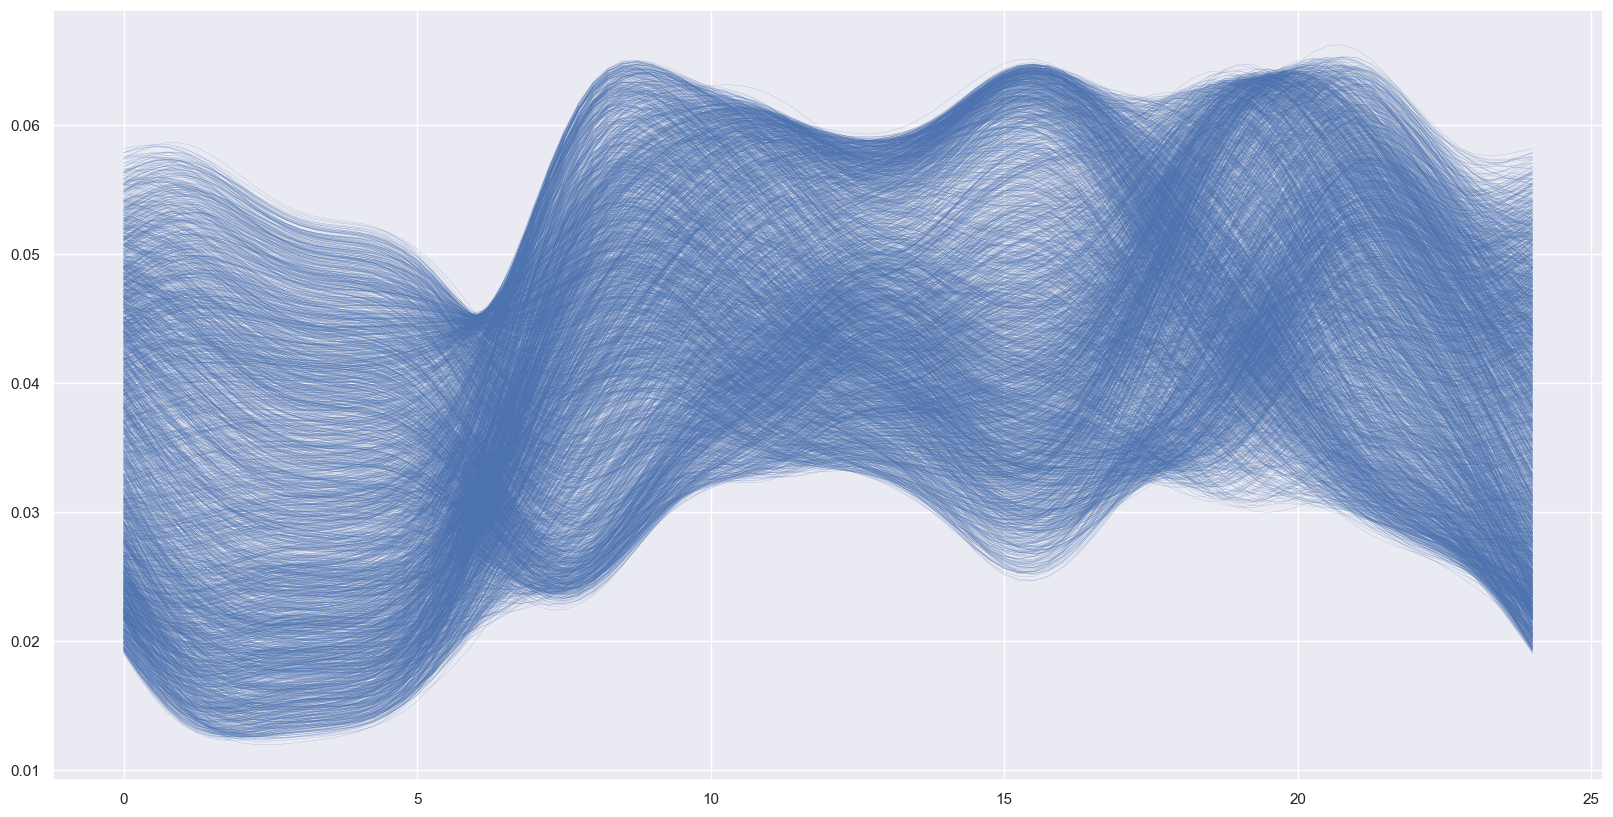

In [151]:
n_clean_runs = W_results.shape[2]
abscissa = [float(x) for x in X.columns]
fig, ax = plt.subplots(figsize=(20, 10))

for i in range(n_clean_runs):
    for k in range(n_components):
        line, = ax.plot(abscissa, H_results[k, :, i], linewidth=0.1, color=colors[0])

In [152]:
H_results_flat = H_results.transpose([0, 2, 1]).reshape((n_components * n_clean_runs, p)) # Flattening the array of profiles
kmeans = KMeans(n_clusters=n_components, n_init=10).fit(H_results_flat)

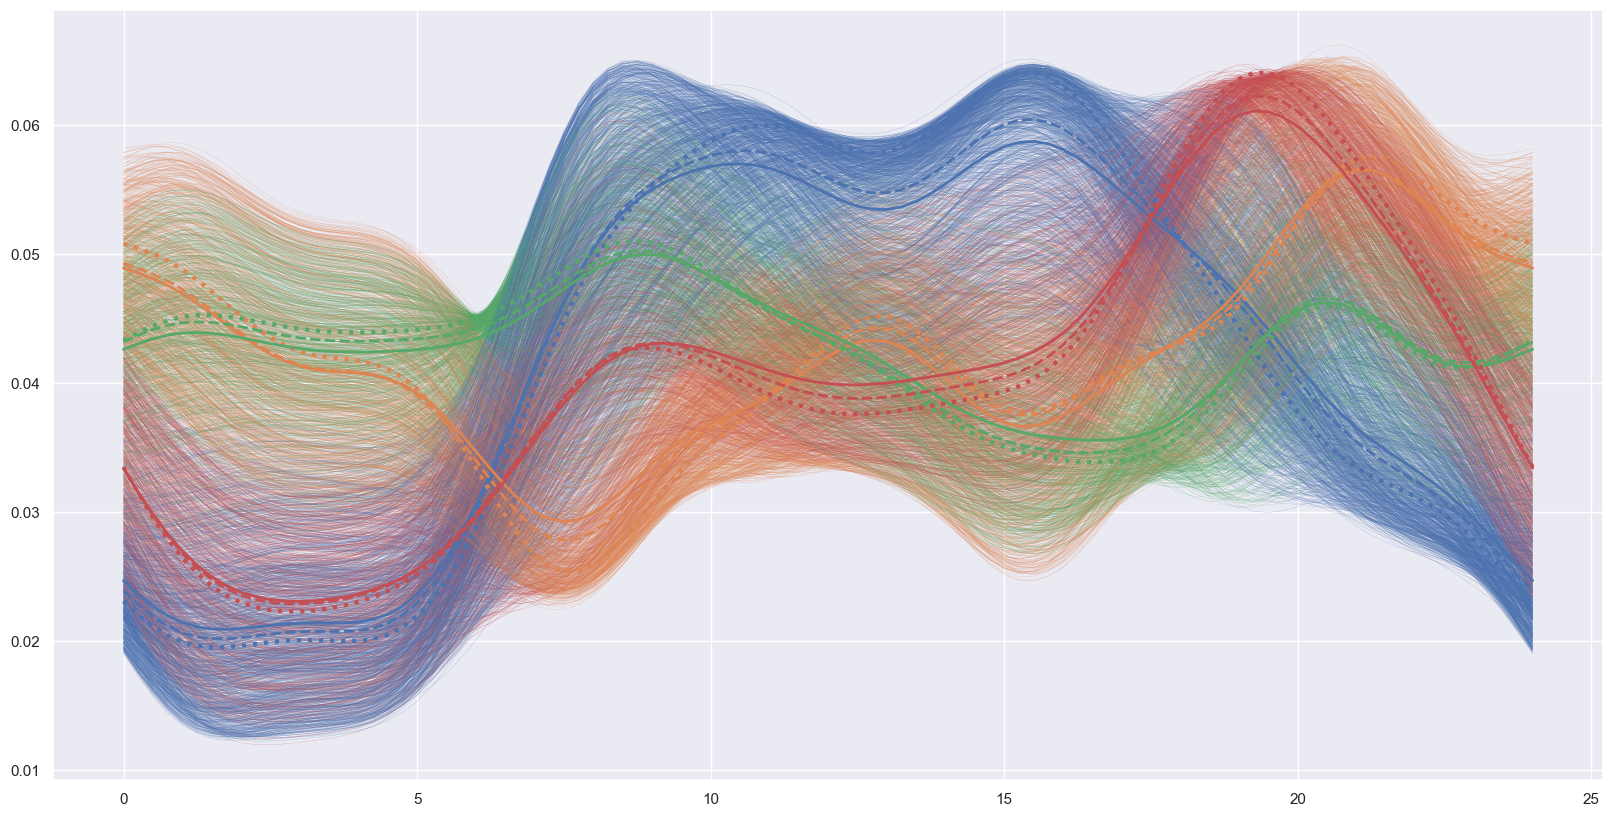

In [153]:
fig, ax = plt.subplots(figsize=(20, 10))

# Plot each profile curve coloring per cluster
for i in range(n_components * n_clean_runs):
    cluster_label = kmeans.labels_[i]
    ax.plot(abscissa, H_results_flat[i, :], linewidth=0.1, color=colors[cluster_label])

# Plot cluster centroids
for i in range(n_components):
    ax.plot(abscissa, kmeans.cluster_centers_[i, :], linewidth=2, color=colors[i])
    ax.plot(abscissa, geometric_median(H_results_flat[kmeans.labels_ == i, :]), linewidth=2, linestyle='dashed', color=colors[i])
    ax.plot(abscissa, geometric_medoid(H_results_flat[kmeans.labels_ == i, :]), linewidth=3, linestyle='dotted', color=colors[i])
    

Let's plot per cluster

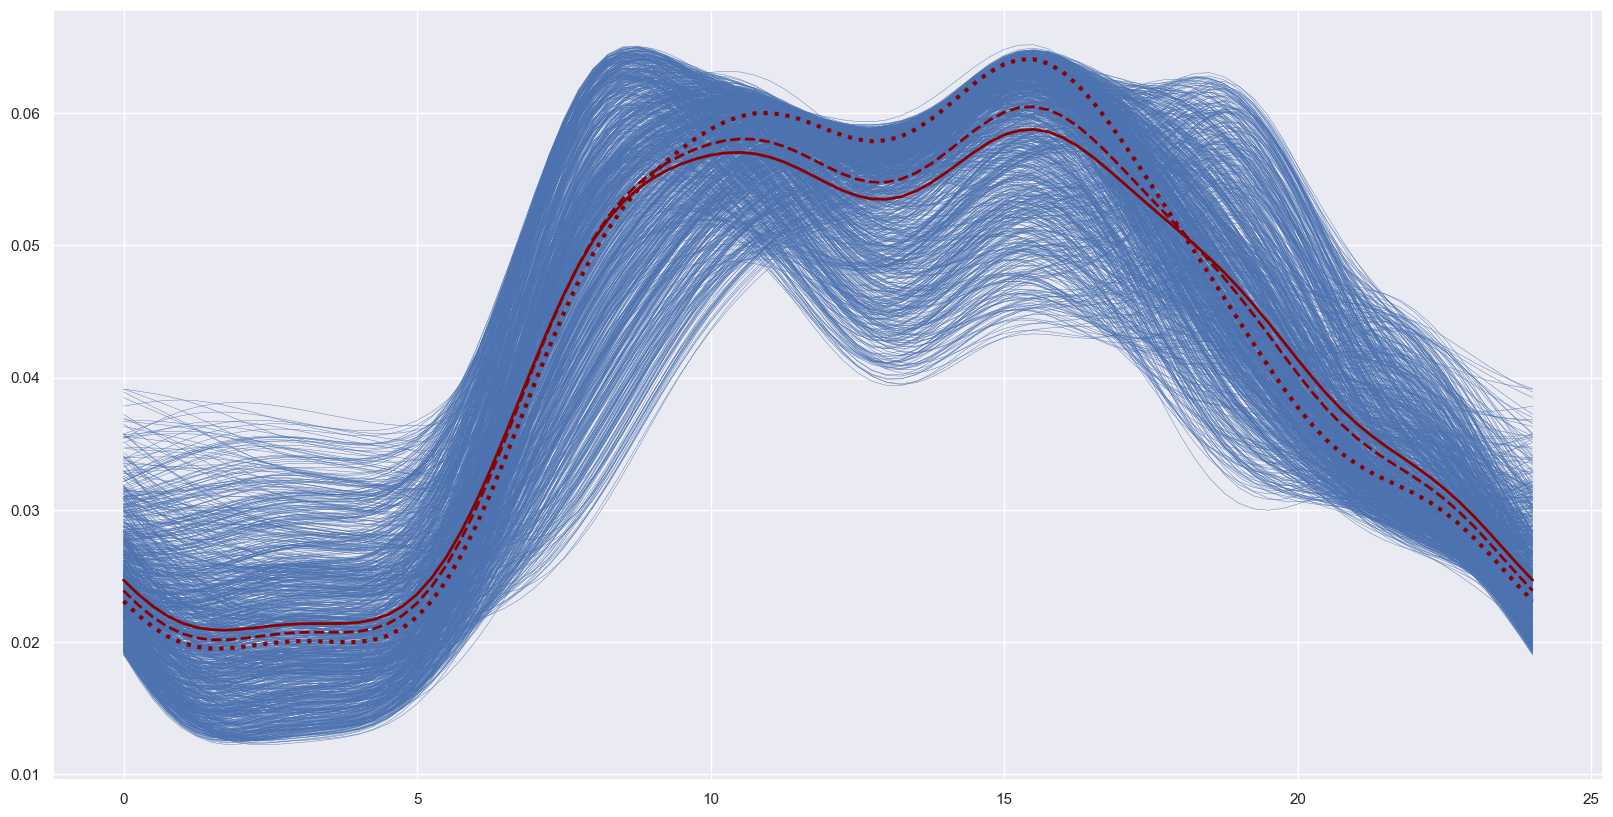

In [156]:
cluster = 0
fig, ax = plt.subplots(figsize=(20, 10))

# Plot each profile curve coloring per cluster
for i in range(n_components * n_clean_runs):
    cluster_label = kmeans.labels_[i]
    if cluster_label == cluster:
        ax.plot(abscissa, H_results_flat[i, :], linewidth=0.3, color=colors[cluster_label])

# Plot cluster centroids
color = 'darkred'
# color = colors[cluster]
ax.plot(abscissa, kmeans.cluster_centers_[cluster, :], linewidth=2, color=color)
ax.plot(abscissa, geometric_median(H_results_flat[kmeans.labels_ == cluster, :]), linewidth=2, linestyle='dashed', color=color)
ax.plot(abscissa, geometric_medoid(H_results_flat[kmeans.labels_ == cluster, :]), linewidth=3, linestyle='dotted', color=color)
# ax.set_ylim((0,0.05))

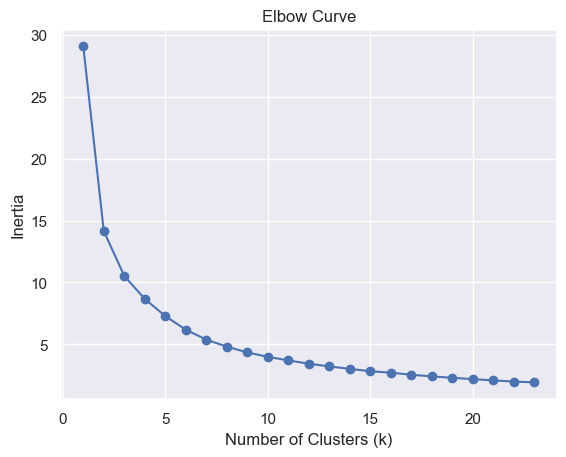

In [157]:
# Seems that there are more than 4 clusters of profiles. Let's try to find how much:

# Calculate inertia for different values of k
inertias = []
k_values = range(1, 24)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(H_results_flat)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

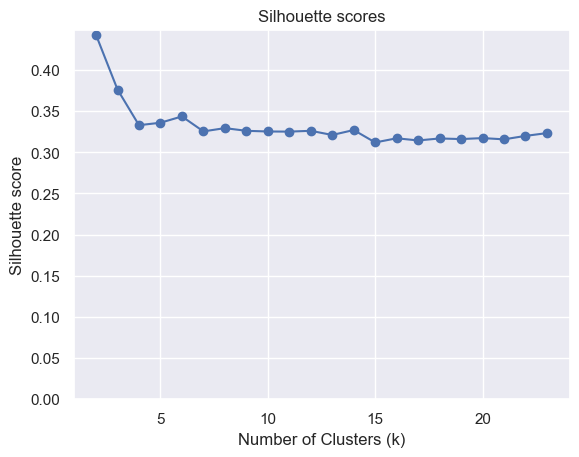

In [93]:
# Calculate silhouette score for different values of k
silhouette_scores = []
k_values = range(2, 24)
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(H_results_flat)
    labels = kmeans.labels_
    score = silhouette_score(H_results_flat, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores')
plt.ylim(bottom=0)
plt.show()

<Axes: >

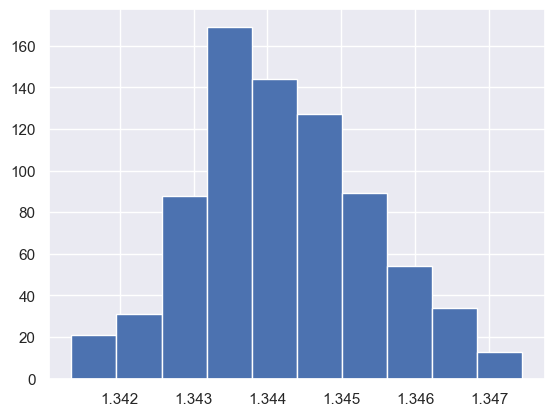

In [158]:
pd.Series(errors).hist()

## Select the solution that is compliant to the physics of the problem

### Cyclic profiles

We want to find solutions for which
$$\text{discontinuity}(H) = \sum_{k=1}^K(H_k(p) - H_k(1))^2$$

In [159]:
H_discontinuity = ((H_results[:, 0, :] - H_results[:, p-1, :])**2).sum(axis=0)

<Axes: >

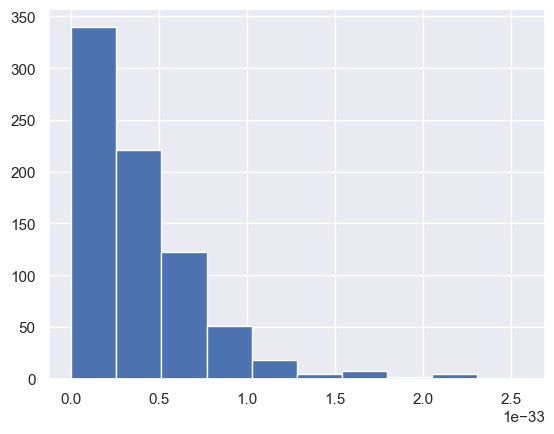

In [160]:
pd.Series(H_discontinuity).hist()

### Total distance of concentration vectors to simplex

The distance to the simplex of one observation $x$ to the simplex $\mathcal{S}(n)$ is the following
$$\text{dist}(x, \mathcal{S}(n)) = \inf_{\substack{y \in \mathcal{S}(n)}} d(x, y)$$

The point $y$ minimizing the distance is:
$$y = \frac{x}{||x||_1}$$

Here we will compute the sum of the distances to the simplex for all vector of concentrations of the matrix $W$

In [161]:
W_proj_simplex = W_results / W_results.sum(axis=1)[:, np.newaxis, :]
W_dist_simplex = np.sqrt(((W_results - W_proj_simplex)**2).sum(axis=1))
W_sum_dist_simplex = W_dist_simplex.sum(axis=0)

<Axes: >

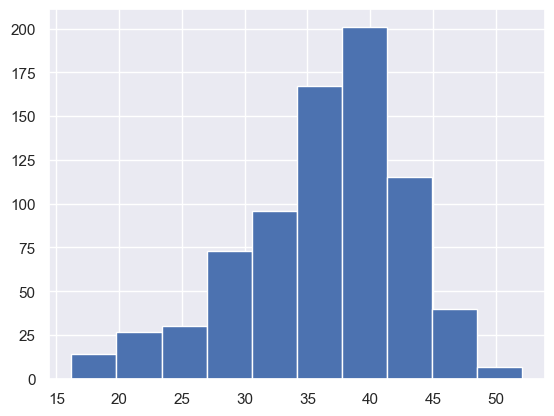

In [162]:
pd.Series(W_sum_dist_simplex).hist()

### Total distance of the components to the p-dimensional simplex

Similarly, the unit l1 norm constraint on the components, having necessarily positive coordinates, result in the components having to lie on the unit 1-sphere

In [163]:
H_proj_unit = np.empty_like(H_results)
for n in range(H_results.shape[2]):
    H_proj_unit[..., n] = normalize_curves(H_results[..., n])
H_dist_unit = np.sqrt(((H_results - H_proj_unit)**2).sum(axis=1))
H_sum_dist_unit = H_dist_unit.sum(axis=0)

<Axes: >

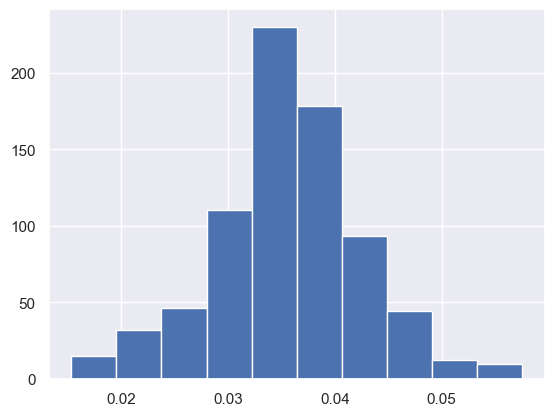

In [164]:
pd.Series(H_sum_dist_unit).hist()

### Scatterplot of the value of the two constraints

In [165]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=H_discontinuity,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex',
    yaxis_title='Discontinuity of the profiles',
    title='Compliance of solutions with physics of the system',
    height=800,
    width=1000
)

# # Show the plot
# fig.show()

In [166]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=H_sum_dist_unit,
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex for W',
    yaxis_title='Sum of distance to the unit sphere for H',
    title='Compliance of solutions with physics of the system',
    height=800,
    width=1000
)

# # Show the plot
# fig.show()

In [167]:
import plotly.graph_objects as go

# Create a scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=W_sum_dist_simplex,
        y=errors / int(X.shape[1] / 24),
        mode='markers',
        hoverinfo='text',
        text=[f'Index: {i}' for i in range(len(W_sum_dist_simplex))]
        )
    )

# Add labels and title
fig.update_layout(
    xaxis_title='Sum of distance to the simplex for W',
    yaxis_title='Reconstruction error',
    title='Compliance of solutions with physics of the system and approximation quality',
    height=800,
    width=1000
)

# # Show the plot
# fig.show()

In [181]:
best_run = 460

H = H_results[..., best_run]
W = W_results[..., best_run]

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Components found by the NMF'}, xlabel='Hour', ylabel='Load (MW)'>)

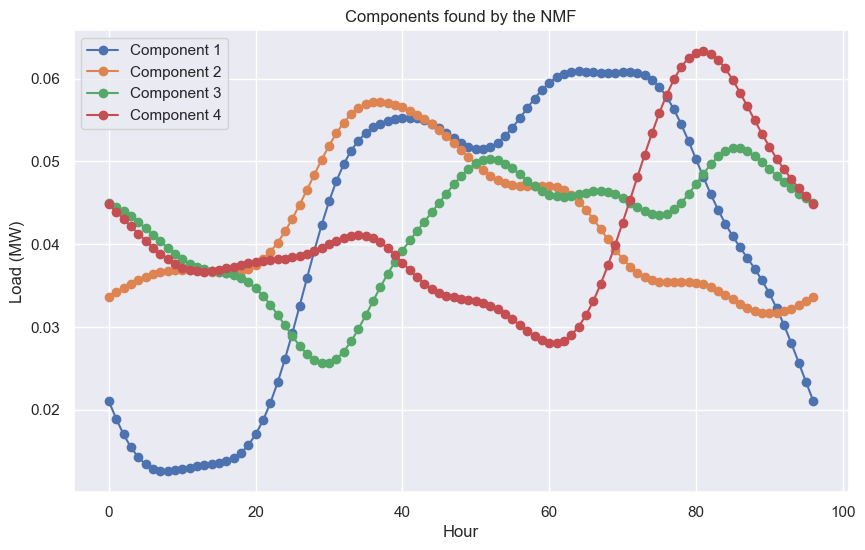

In [173]:
plot_components(H)

In [174]:
W = pd.DataFrame(W, index=df.index, columns=[f"Component {k+1}" for k in range(n_components)])
W[unit_info.columns] = df[unit_info.columns]
W

Component 1   Component 2  Component 3  \
Calabria_2021-01-02_Saturday        0.330476  2.372023e-02     0.291793   
Calabria_2021-01-03_Holiday         0.374889  8.743728e-05     0.405766   
Calabria_2021-01-04_Working day     0.510744  9.787518e-02     0.161986   
Calabria_2021-01-05_Working day     0.353291  2.855853e-01     0.051254   
Calabria_2021-01-06_Holiday         0.382930  7.429440e-02     0.403204   
...                                      ...           ...          ...   
South_2022-12-26_Holiday            0.314731  1.823879e-11     0.374503   
South_2022-12-27_Working day        0.554439  2.595958e-02     0.113019   
South_2022-12-28_Working day        0.682593  3.841540e-14     0.320119   
South_2022-12-29_Working day        0.321111  2.355095e-01     0.196043   
South_2022-12-30_Working day        0.512658  4.586626e-07     0.070572   

                                 Component 4    region  year month  \
Calabria_2021-01-02_Saturday        0.357159  Calabria  2021    01   
Calabria_2021-01-03_Holiday         0.224977  Calabria  2021    01   
Calabria_2021-01-04_Working day     0.236605  Calabria  2021    01   
Calabria_2021-01-05_Working day     0.311316  Calabria  2021    01   
Calabria_2021-01-06_Holiday         0.142801  Calabria  2021    01   
...                                      ...       ...   ...   ...   
South_2022-12-26_Holiday            0.323635     South  2022    12   
South_2022-12-27_Working day        0.313350     South  2022    12   
South_2022-12-28_Working day        0.014200     South  2022    12   
South_2022-12-29_Working day        0.247878     South  2022    12   
South_2022-12-30_Working day        0.430494     South  2022    12   

                                     daytype  
Calabria_2021-01-02_Saturday        Saturday  
Calabria_2021-01-03_Holiday          Holiday  
Calabria_2021-01-04_Working day  Working day  
Calabria_2021-01-05_Working day  Working day  
Calabria_2021-01-06_Holiday          Holiday  
...                                      ...  
South_2022-12-26_Holiday             Holiday  
South_2022-12-27_Working day     Working day  
South_2022-12-28_Working day     Working day  
South_2022-12-29_Working day     Working day  
South_2022-12-30_Working day     Working day  

[11646 rows x 8 columns]

In [175]:
W[(W.region == 'North')&(W.daytype == 'Working day')].sort_index().tail(20)

Component 1  Component 2  Component 3  \
North_2022-12-01_Working day     0.339838     0.402881     0.092551   
North_2022-12-02_Working day     0.312710     0.446491     0.115150   
North_2022-12-05_Working day     0.470647     0.332036     0.101061   
North_2022-12-06_Working day     0.331691     0.407520     0.081950   
North_2022-12-07_Working day     0.323542     0.435754     0.063435   
North_2022-12-09_Working day     0.391945     0.323780     0.151112   
North_2022-12-12_Working day     0.471632     0.328538     0.097231   
North_2022-12-13_Working day     0.347177     0.436372     0.129309   
North_2022-12-14_Working day     0.325372     0.444954     0.110869   
North_2022-12-15_Working day     0.348897     0.425973     0.160313   
North_2022-12-16_Working day     0.321806     0.490810     0.102910   
North_2022-12-19_Working day     0.443780     0.378183     0.072710   
North_2022-12-20_Working day     0.338642     0.433151     0.119822   
North_2022-12-21_Working day     0.351427     0.445457     0.087466   
North_2022-12-22_Working day     0.343311     0.468584     0.066036   
North_2022-12-23_Working day     0.284676     0.542617     0.024803   
North_2022-12-27_Working day     0.459000     0.240059     0.106041   
North_2022-12-28_Working day     0.431680     0.276335     0.076565   
North_2022-12-29_Working day     0.371528     0.320028     0.089204   
North_2022-12-30_Working day     0.374472     0.273168     0.109471   

                              Component 4 region  year month      daytype  
North_2022-12-01_Working day     0.162234  North  2022    12  Working day  
North_2022-12-02_Working day     0.121661  North  2022    12  Working day  
North_2022-12-05_Working day     0.096623  North  2022    12  Working day  
North_2022-12-06_Working day     0.176044  North  2022    12  Working day  
North_2022-12-07_Working day     0.173550  North  2022    12  Working day  
North_2022-12-09_Working day     0.132744  North  2022    12  Working day  
North_2022-12-12_Working day     0.103372  North  2022    12  Working day  
North_2022-12-13_Working day     0.083738  North  2022    12  Working day  
North_2022-12-14_Working day     0.115504  North  2022    12  Working day  
North_2022-12-15_Working day     0.060886  North  2022    12  Working day  
North_2022-12-16_Working day     0.080398  North  2022    12  Working day  
North_2022-12-19_Working day     0.104526  North  2022    12  Working day  
North_2022-12-20_Working day     0.105007  North  2022    12  Working day  
North_2022-12-21_Working day     0.112555  North  2022    12  Working day  
North_2022-12-22_Working day     0.118981  North  2022    12  Working day  
North_2022-12-23_Working day     0.143885  North  2022    12  Working day  
North_2022-12-27_Working day     0.196778  North  2022    12  Working day  
North_2022-12-28_Working day     0.216995  North  2022    12  Working day  
North_2022-12-29_Working day     0.218610  North  2022    12  Working day  
North_2022-12-30_Working day     0.243334  North  2022    12  Working day

In [176]:
W_region = W.groupby('region')[[f"Component {k+1}" for k in range(n_components)]].sum()
W_region = W_region.div(W_region.sum(axis=1), axis=0)
W_region

Component 1  Component 2  Component 3  Component 4
region                                                          
Calabria         0.280766     0.181586     0.250449     0.287198
Centre.North     0.302419     0.295456     0.245275     0.156850
Centre.South     0.310829     0.173870     0.297240     0.218062
North            0.282471     0.340351     0.194075     0.183103
Sardinia         0.160988     0.327471     0.229035     0.282505
Sicily           0.223223     0.186302     0.276966     0.313509
South            0.228882     0.228903     0.251262     0.290953

Text(0, 0.5, '')

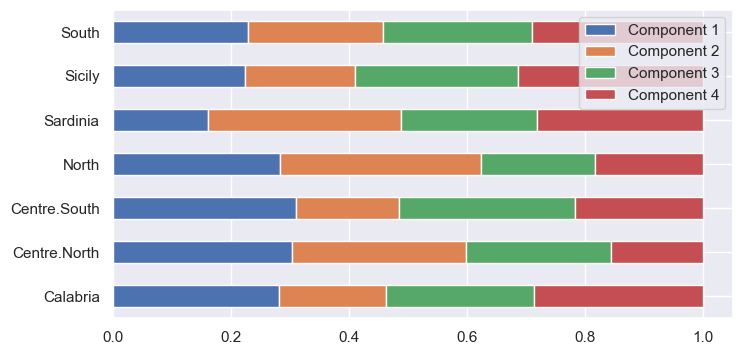

In [177]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
W_region.plot.barh(stacked=True, ax=ax)
ax.set_ylabel("")

<Axes: xlabel='component', ylabel='concentration'>

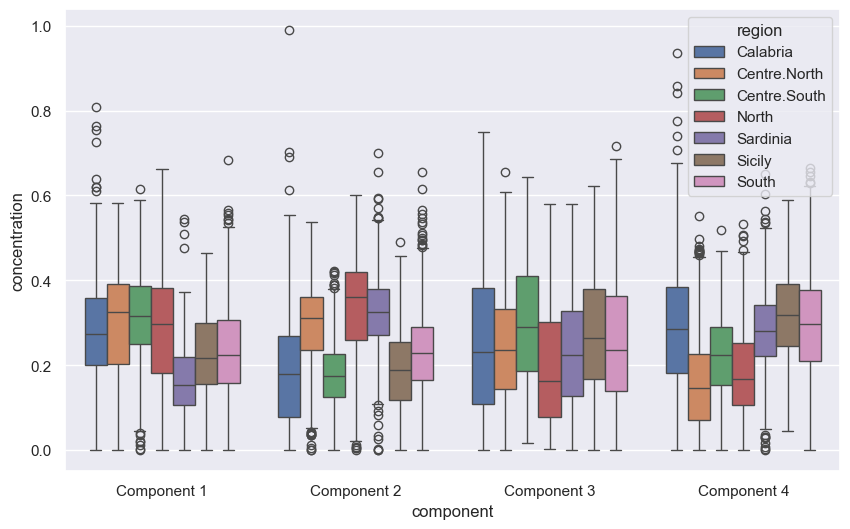

In [178]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='component',
    y='concentration',
    hue='region',
)

<Axes: xlabel='month', ylabel='concentration'>

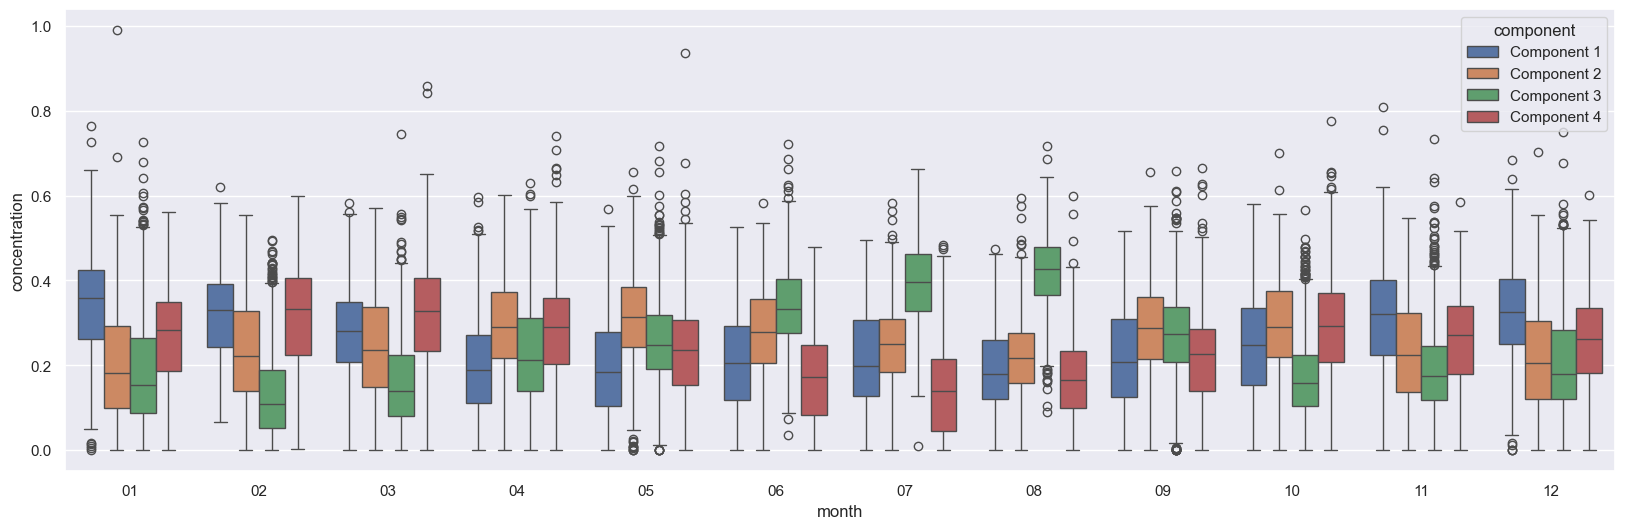

In [179]:
plt.figure(figsize=(20,6))
sns.boxplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
)

<Axes: xlabel='month', ylabel='concentration'>

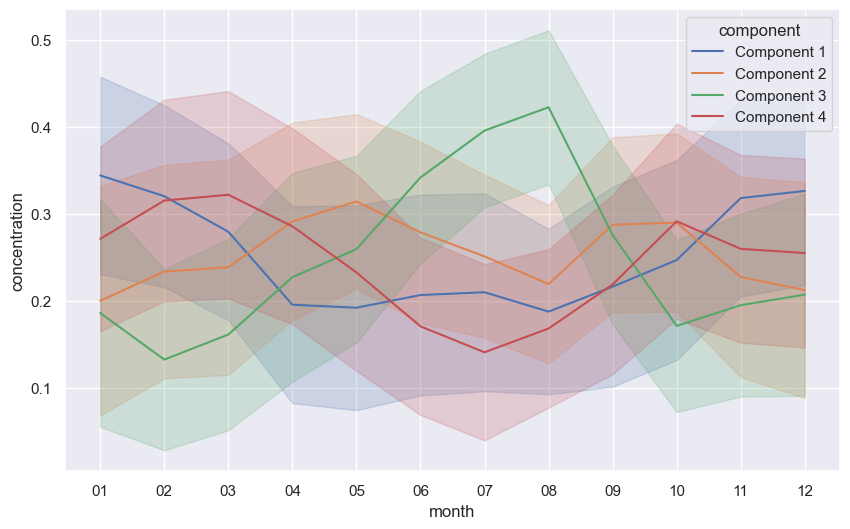

In [180]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=W.melt(id_vars=unit_info.columns.to_list(), var_name='component', value_name='concentration'),
    x='month',
    y='concentration',
    hue='component',
    errorbar='sd'
)

## Save results

In [182]:
if smoothed:
    outfile = f'data/nmf_results/WHopt_{n_components}comp_smoothed_{n_runs}runs.npz'
else:
    outfile = f'data/nmf_results/WHopt_{n_components}comp_{n_runs}runs.npz'
np.savez(outfile, W=W, H=H)
print("Saved results at", outfile)

Saved results at data/nmf_results/WHopt_4comp_smoothed_1000runs.npz


___

# TESTS

In [136]:
n_components_list = [3, 4]

for n_components in n_components_list:

    W_init = initialize_W(X, n_components)
    H_init = np.ones((n_components, p)) / p

    WH_init = np.dot(W_init, H_init)

    # Load the arrays from the .npz file
    data = np.load(f'data/nmf_results/uniform_{n_components}comp.npz')

    iterations = data['iterations']
    H_results = data['H_results'][..., iterations > 100]
    W_results = data['W_results'][..., iterations > 100]

    random_obs = random.randint(0, W_results.shape[2]-1)

    W_random = W_results[..., random_obs]
    H_random = H_results[..., random_obs]

    WH_random = np.dot(W_random, H_random)

    X_fpca = pd.read_csv(f'data/daily_curves_reconstructed_{n_components}PCs.csv', index_col=0)

    # Compute the Frobenius norm between X and the product W_init * H_init
    frobenius_norm_init = np.linalg.norm(X - WH_init, 'fro')
    frobenius_norm_final = np.linalg.norm(X - WH_random, 'fro')
    frobenius_norm_fpca = np.linalg.norm(X - X_fpca, 'fro')

    print(f'### {n_components} components ###')
    print("Frobenius Norm of the initial residual matrix:", frobenius_norm_init)
    print("Frobenius Norm of the final residual matrix:", frobenius_norm_final)
    print("Frobenius Norm of the FPCA residual matrix:", frobenius_norm_fpca)
    print('\n')

### 3 components ###
Frobenius Norm of the initial residual matrix: 3.7358385772724887
Frobenius Norm of the final residual matrix: 0.949199529377695
Frobenius Norm of the FPCA residual matrix: 0.7711263023212324


### 4 components ###
Frobenius Norm of the initial residual matrix: 3.7358385772724887
Frobenius Norm of the final residual matrix: 0.7607376211325353
Frobenius Norm of the FPCA residual matrix: 0.6634465209563668




In [36]:
errors[644]

0.6540102320810631

In [37]:
pd.Series(errors).quantile(np.linspace(0, 1, 21))

0.00    0.652081
0.05    0.653201
0.10    0.653387
0.15    0.653528
0.20    0.653644
0.25    0.653732
0.30    0.653810
0.35    0.653886
0.40    0.653961
0.45    0.654024
0.50    0.654114
0.55    0.654191
0.60    0.654272
0.65    0.654357
0.70    0.654444
0.75    0.654533
0.80    0.654648
0.85    0.654759
0.90    0.654923
0.95    0.655146
1.00    0.756661
dtype: float64

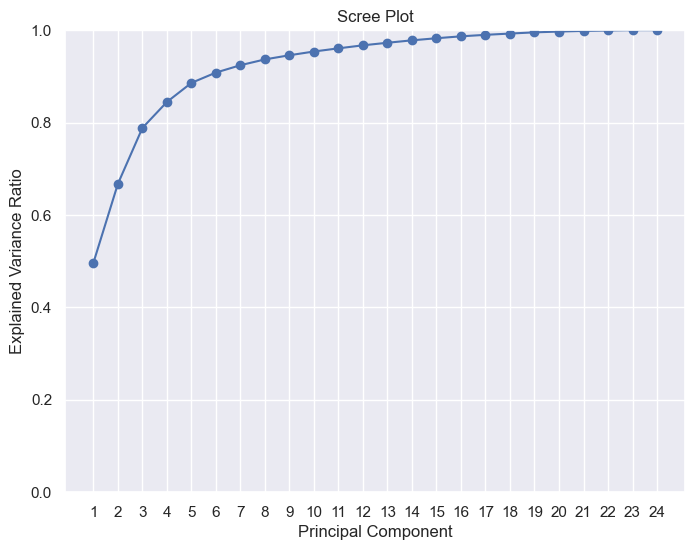

In [74]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Scree plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
# plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, pca.n_components_ + 1))
plt.ylim((0,1))
plt.grid(True)
plt.show()

In [75]:
np.cumsum(pca.explained_variance_ratio_)

array([0.49630093, 0.66741324, 0.78837141, 0.84461045, 0.88591071,
       0.90821743, 0.92415001, 0.93673463, 0.94572021, 0.95382268,
       0.96067938, 0.96721481, 0.97276266, 0.97799972, 0.98254862,
       0.98667156, 0.98989461, 0.99267498, 0.99526384, 0.99697613,
       0.99841413, 0.99930394, 1.        , 1.        ])

In [57]:
# Perform PCA
pca = PCA(n_components='mle')
X_pca = pca.fit_transform(X)

In [58]:
pca.n_components_

23